# EE 679 Computing Assignment 1

## Signal Sysnthesis based on source-filter model

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

from pydub import AudioSegment

## Question 1

Given the following specification for a single-formant resonator, obtain the transfer function of the filter H(z) from the relation between resonance frequency / bandwidth, and the pole angle / radius. Plot filter magnitude response (dB magnitude versus frequency) and impulse response. <br>

F1 (formant) = 900 Hz

B1(bandwidth) = 200 Hz

Fs (sampling freq) = 16 kHz 

### Answer

We obtain the transfer function 

$$ H(z) = \frac{1}{1 - 2rcos(\theta)z^{-1} + r^2z^{-2}} $$

where 

$\theta = 2\pi F_i T $ (Pole angle)
 
$r = e^{- \pi B_i T}$ (Pole radius)

T here is the sampling interval ($ \frac{1}{f_s}$), $F_i$ is the frequency of formant i and $B_i$ is the bandwidth of formant i

In [2]:
f1 = 900
b1 = 200
fs = 16000

pi = np.pi

T = 1/fs  #sampling interval
theta = 2 * pi * f1 * T
sigma = b1 * pi * T

r = np.exp(-sigma)

Hz = signal.dlti([1], [1, -2*r*np.cos(theta), r**2]) #creating a discrete time lti system
Hz

TransferFunctionDiscrete(
array([1.]),
array([ 1.        , -1.80412535,  0.92446525]),
dt: True
)

Now we can obtain the magnitude response of this system by using the freqz function of scipy library and plot tit on a dB scale

In [3]:
# Ref: https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.freqz.html

w, h = signal.freqz(Hz.num, Hz.den)
print(w.shape)
print(h.shape)

# w: The normalized frequencies at which h was computed, in radians/sample.
# h: The frequency response.

(512,)
(512,)


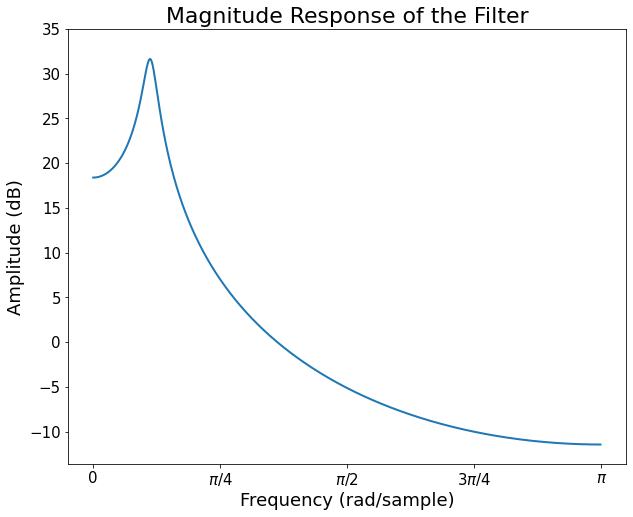

In [4]:
plt.figure(figsize = (10,8))
plt.plot(w, 20 * np.log10(abs(h)), linewidth = 2)
plt.title("Magnitude Response of the Filter", fontsize = 22)
plt.ylabel('Amplitude (dB)', fontsize = 18)
plt.xlabel('Frequency (rad/sample)', fontsize = 18)
plt.xticks([pi * x / 4 for x in range(5)], ['0', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'], fontsize = 15)
plt.yticks([-10,-5,0,5,10,15,20,25,30, 35], fontsize = 15);

In [5]:
w[np.argmax(20 * np.log10(abs(h)))]  #checking whether peak is at correct frequency

0.34974761963792617

In [6]:
theta #should match the above value (with some small error)

0.3534291735288517

We can also obtain the impulse response using the dimpulse function on H(z) and choosing a sufficiently large number of samples (here 150)

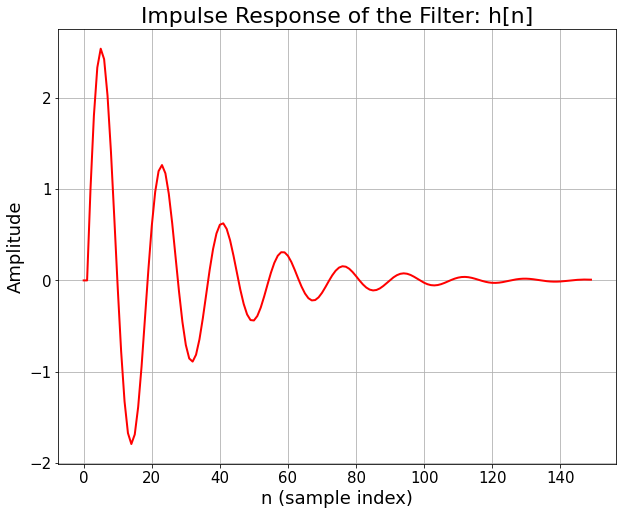

In [7]:
samples, response = signal.dimpulse(Hz, t = range(150))

plt.figure(figsize = (10,8))
plt.plot(samples, response[0], linewidth = 2, color = 'r')

plt.title("Impulse Response of the Filter: h[n]", fontsize = 22)
plt.ylabel('Amplitude', fontsize = 18)
plt.xlabel('n (sample index)', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid();

# Question 2

Excite the above resonator (“filter”) with a periodic source excitation of F0 = 160 Hz. You can
approximate the source signal by a narrow-triangular pulse train. Compute the output of the
source-filter system over the duration of 0.5 second using the difference equation implementation
of the LTI system. Plot the time domain waveform over a few pitch periods so that you can
observe waveform characteristics. Play out the 0.5 sec duration sound and comment on the
sound quality.

### Answer


A triangular pulse of **width 40** and **height 1** has been used in this part as an approximation of the glottal pulse. To obtain the pulse train this triangular pulse is convolved with an impulse train, to get the **pulse train** (pulse repeated with period equal to period of the impulse train). The following plots have been shown in the next cell output:

1) The triangular pulse

2) The impulse train: We have 16000 samples per second (sampling rate 16kHz) and we want a duration of 0.5 seconds for the sound, so we need **8000 samples** in the impulse train

3) The pulse train: The convolution output of 1) and 2) - 8000 triangular pulses. This is the **input source excitation x[n]**

4) Magnified (zoomed) view of 3) to show the pulse train clearly

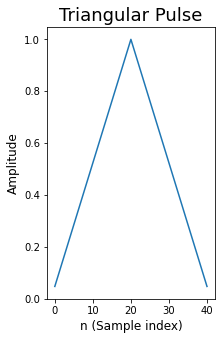

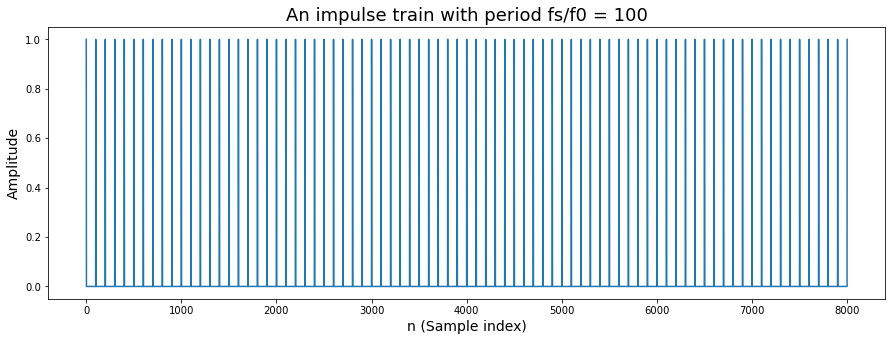

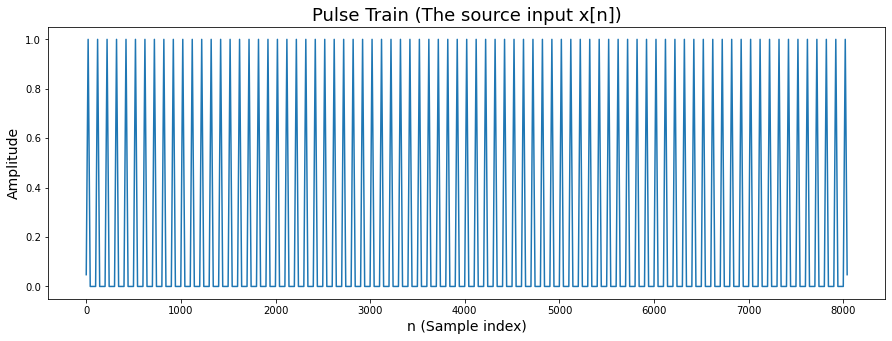

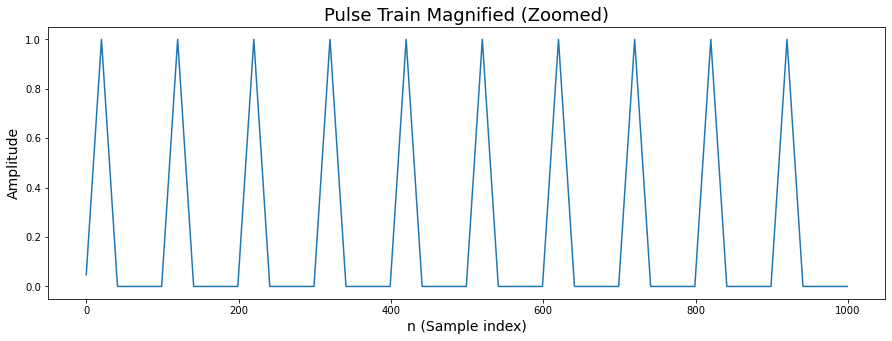

In [8]:
pw = 40 #pulse width
pulse = signal.windows.triang(pw + 1)
plt.figure(figsize = (3,5))
plt.plot(pulse)
plt.title("Triangular Pulse", fontsize = 18)
plt.xlabel("n (Sample index)", fontsize = 12)
plt.ylabel("Amplitude", fontsize = 12)
plt.show()

f0 = 160 #pitch
dur = 0.5 #duration to play the sound
P = int(fs/f0) #period of impulse train
num_samples = int(fs * dur)
imp = signal.unit_impulse(num_samples + 1, [x*P for x in range(0,int(num_samples/P) + 1)])
plt.figure(figsize = (15,5))
plt.plot(imp)
plt.title("An impulse train with period fs/f0 = 100", fontsize = 18)
plt.xlabel("n (Sample index)", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
plt.show();

# 16000 samples per s, duration 0.5 s so we need 8000 samples in s[n]


xn = signal.convolve(pulse, imp)

plt.figure(figsize = (15,5))
plt.plot(xn)
plt.title("Pulse Train (The source input x[n])", fontsize = 18)
plt.xlabel("n (Sample index)", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
plt.show();

plt.figure(figsize = (15,5))
plt.plot(xn[0:1000])
plt.title("Pulse Train Magnified (Zoomed)", fontsize = 18)
plt.xlabel("n (Sample index)", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
plt.show();

This x[n] is then filtered through h[n] (using the **difference equation implementation** with a for loop, instead of directly convolving h[n] and x[n]) to get the **sound waveform s[n]**. 

The difference equation is as follows:

$$ s[n] = x[n] + 1.804 \times s[n-1] - 0.9245 \times s[n-2] $$ 

The coefficients are obtained from the numerator and denominator of H(z)

In [9]:
Hz

TransferFunctionDiscrete(
array([1.]),
array([ 1.        , -1.80412535,  0.92446525]),
dt: True
)

In the next cell, the following plots are shown:

1) Sound waveform s[n] (which is nothing but the convolution of x[n] and h[n])

2) Magnified Sound Waveform

And then the audio is played

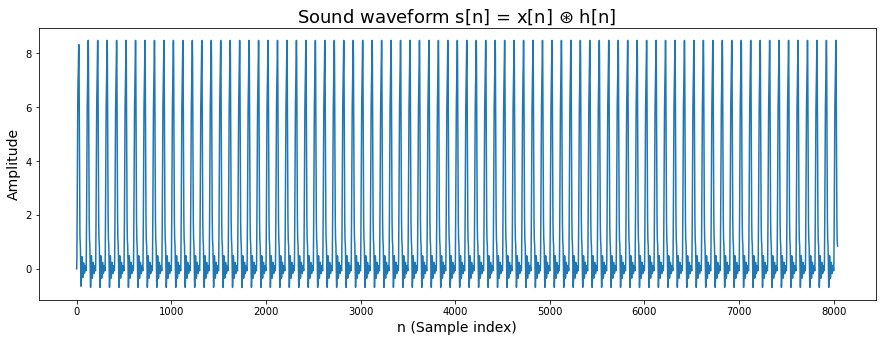

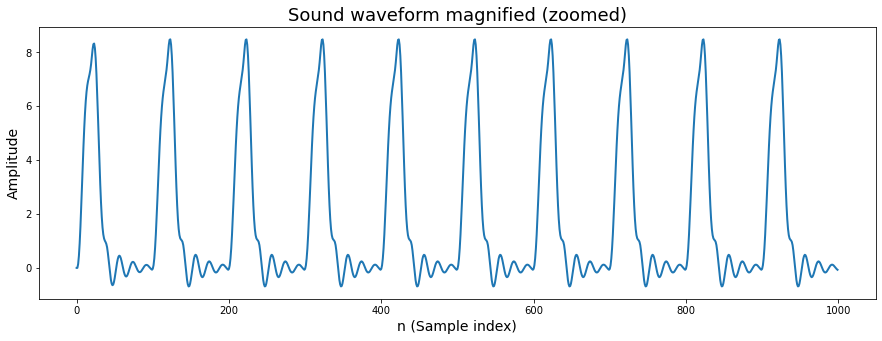

In [10]:
hn = response[0].reshape(150)

# Difference Equation Implementation
sn = np.zeros(xn.shape)
for i in range(2,len(xn)):
    sn[i] = Hz.num[0]*xn[i] - Hz.den[1] * sn[i-1] - Hz.den[2]* sn[i-2]
    
#Implementation using convolution:
# sn = signal.convolve(xn, hn)   

plt.figure(figsize = (15,5))
plt.plot(sn)
plt.title("Sound waveform s[n] = x[n] $\circledast$ h[n]", fontsize = 18)
plt.xlabel("n (Sample index)", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
plt.show();


plt.figure(figsize = (15,5))
plt.plot(sn[0:1000], linewidth = 2)
plt.title("Sound waveform magnified (zoomed)", fontsize = 18)
plt.xlabel("n (Sample index)", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
plt.show();

In [11]:
from IPython.display import Audio
import time

Audio(sn, rate = 16000)

### Comments on Sound Quality:

The sound is like a note on a musical instrument. It is somewhat muffled. The humanness in the sound is quite less. This might be because we have used a triangular pulse instead of the glottal pulse shape and because we have only used a second order system to model the speech (instead of a multiple formant model).

# Question 3

Vary the parameters as indicated below; plot and comment on the differences in waveform and in
sound quality for the different parameter combinations.

(a) F0 = 120 Hz, F1 = 300 Hz, B1 = 100 Hz

(b) F0 = 120 Hz, F1=1100 Hz, B1 = 200 Hz

(c) F0 = 180 Hz, F1 = 300 Hz, B1 = 100 Hz

### Answer


We can functionalise the code for using the same methods as in Q2 for multiple combinations of F0, F1, B1
The next cell presents this function, after which the combinations a), b), c) are implemented

In [12]:
# Functionalising the code

def generate_sound(f0 = 160, f1 = 900, b1 = 200, fs = 16000, pw = 40, dur = 0.5):
    
    pi = np.pi

    T = 1/fs  #sampling interval
    theta = 2 * pi * f1 * T
    sigma = b1 * pi * T
    r = np.exp(-sigma)
    
    Hz = signal.dlti([1], [1, -2*r*np.cos(theta), r**2])
    samples, response = signal.dimpulse(Hz, t = range(150))
    
    plt.plot(samples, response[0], linewidth = 2, color = 'r')

    plt.title("Impulse Response of the Filter: h[n]", fontsize = 18)
    plt.ylabel('Amplitude', fontsize = 16)
    plt.xlabel('n (sample index)', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid();
    
    
    pulse = signal.windows.triang(pw + 1)  #triangular pulse
#     plt.figure(figsize = (3,5))
#     plt.plot(pulse)
#     plt.title("Triangular Pulse", fontsize = 18)
#     plt.show();

    P = int(fs/f0) #period of impulse train
    num_samples = int(fs * dur)
    imp = signal.unit_impulse(num_samples + 1, [x*P for x in range(0,int(num_samples/P) + 1)])
#     plt.figure(figsize = (15,4))
#     plt.plot(imp)
#     plt.title("An impulse train with period fs/f0 = 100", fontsize = 18)
#     plt.show();

    xn = signal.convolve(pulse, imp)  #generating the source signal (pulse train)

#     plt.figure(figsize = (15,4))
#     plt.plot(xn)
#     plt.title("Pulse Train (The source input x[n])", fontsize = 18)
#     plt.show();

    plt.figure(figsize = (15,4))
    plt.plot(xn[0:1000])
    plt.title("Pulse Train x[n] Magnified (Zoomed)", fontsize = 18)
    plt.xlabel("n (Sample index)", fontsize = 14)
    plt.ylabel("Amplitude", fontsize = 14)
    plt.show();
    
    hn = response[0].reshape(150)
    
    #Difference Equation Implementation
    sn = np.zeros(xn.shape)
    for i in range(2,len(xn)):
        sn[i] = Hz.num[0]*xn[i] - Hz.den[1] * sn[i-1] - Hz.den[2]* sn[i-2]
    
    #Implementation using convolution:
#     sn = signal.convolve(xn, hn)

#     plt.figure(figsize = (15,4))
#     plt.plot(sn)
#     plt.title("Sound waveform s[n] = x[n] $\circledast$ h[n]", fontsize = 18)
#     plt.show();


    plt.figure(figsize = (15,4))
    plt.plot(sn[0:1000])
    plt.title("Sound waveform magnified (zoomed)", fontsize = 18)
    plt.xlabel("n (Sample index)", fontsize = 14)
    plt.ylabel("Amplitude", fontsize = 14)
    plt.show();
    
    return Audio(sn, rate = fs)

### Original: f0 = 160 Hz, f1 = 900 Hz, b1 = 200 Hz

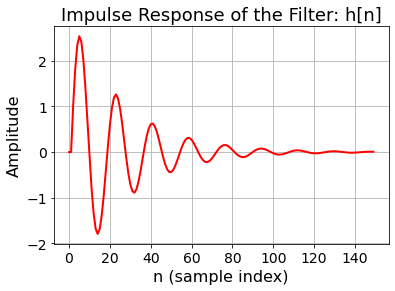

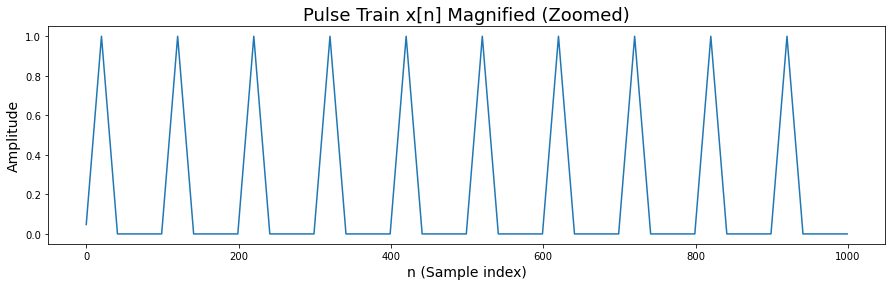

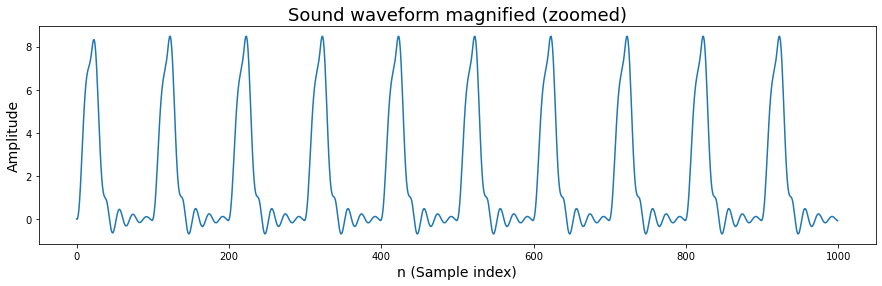

In [13]:
generate_sound() #original

### Part a) f0 = 120 Hz, f1 = 300 Hz, b1 = 100 Hz

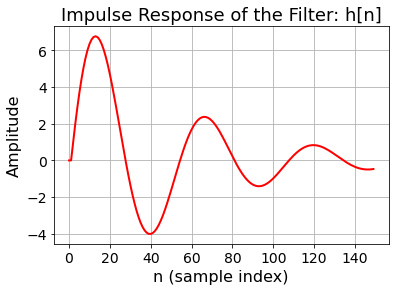

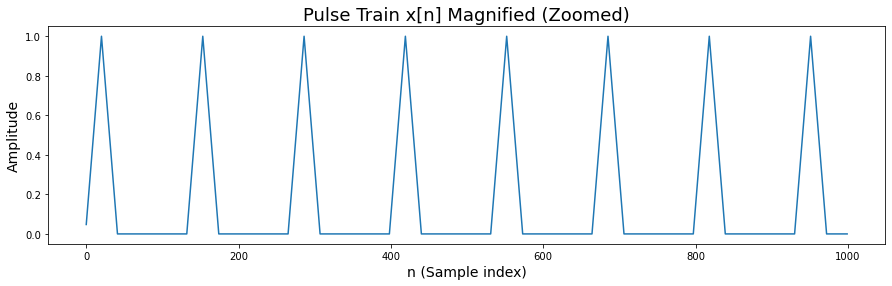

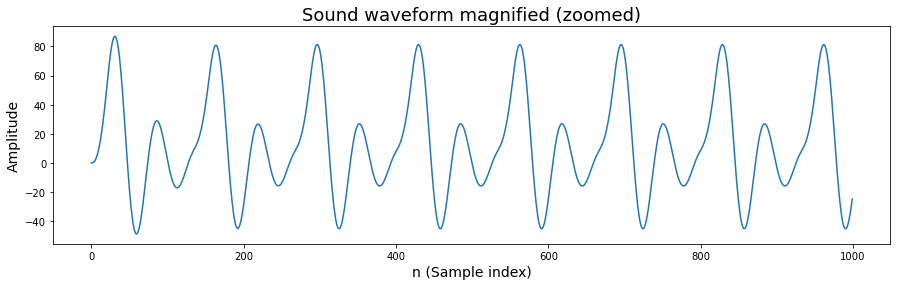

In [14]:
generate_sound(f0 = 120, f1 = 300, b1 = 100)

### Part b)  f0 = 120 Hz, f1 = 1100 Hz, b1 = 200 Hz

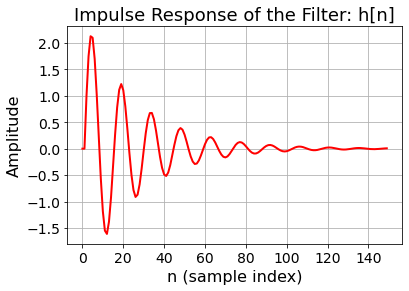

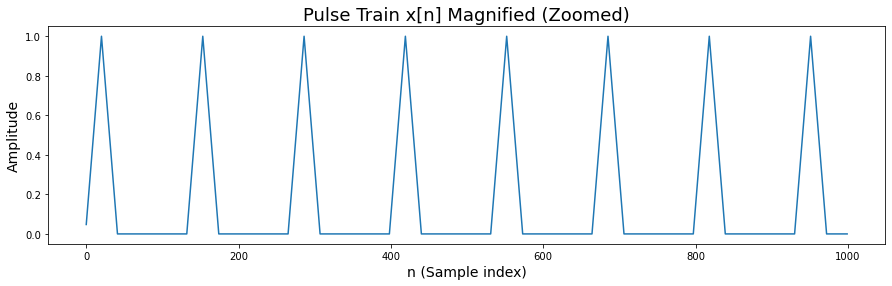

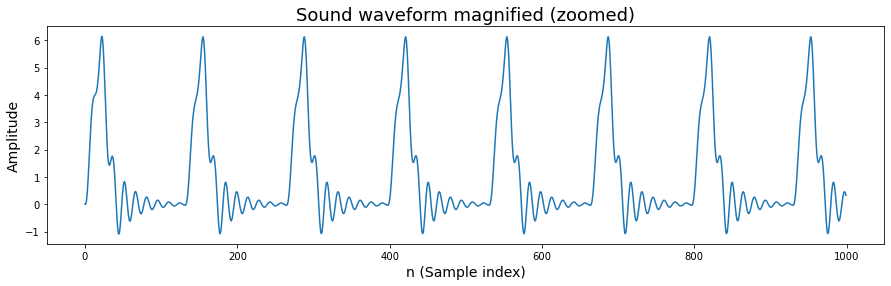

In [15]:
generate_sound(f0 = 120, f1 = 1100, b1 = 200)

### Part c)  f0 = 180 Hz, f1 = 300 Hz, b1 = 100 Hz

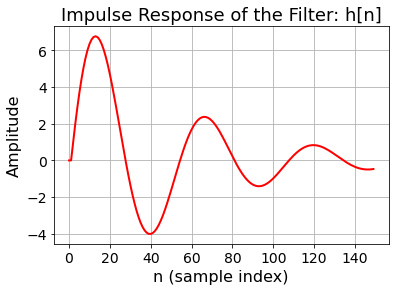

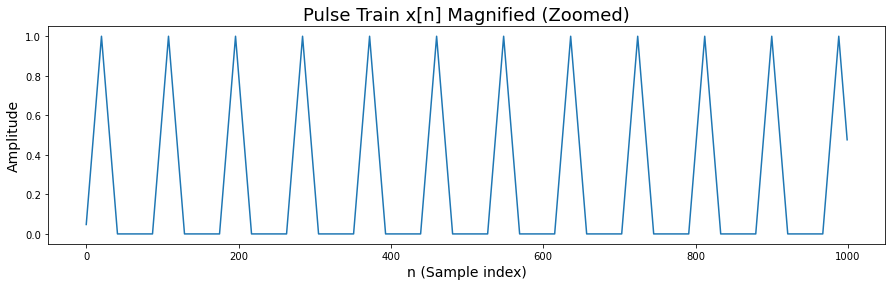

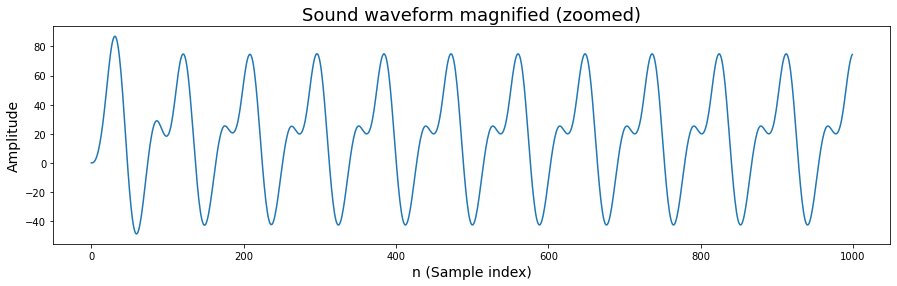

In [16]:
generate_sound(f0 = 180, f1 = 300, b1 = 100)

### Comments:

We have the following combinations:

(a) F0 = 120 Hz, F1 = 300 Hz, B1 = 100 Hz

(b) F0 = 120 Hz, F1=1100 Hz, B1 = 200 Hz

(c) F0 = 180 Hz, F1 = 300 Hz, B1 = 100 Hz



1) **Quality (timbre) of sound**: It depends on the **waveform pattern**. The pattern depends on the impulse response (and so F1 and B1). The impulse response and hence the waveform pattern is same for a) and c) since the formant frequency (F1) and bandwidth (B1) are same. In b) we have a different F1, B1 combination, so the waveform pattern is different.


2) **Pitch of the sound**: It depends on the **frequency** of the waveform which depends only on the source (F0) and is hence same for a) and b) ( = 120 Hz) and different for c) ( = 180 Hz)


So:

a) and b) are like the same note on two different instruments and <br>

a) and c) are like two different notes (120 Hz, 180 Hz respectively) on the same instrument

# Question 4

In place of the simple single-resonance signal, synthesize the following more realistic vowel
sounds at two distinct pitches (F0 = 120 Hz, F0 = 220 Hz). Keep the bandwidths constant at 100
Hz for all formants. Duration of sound: 0.5 sec. Comment on the sound quality across the
different sounds. Plot a few periods of any 2 examples.

Vowel  F1,   F2,   F3

/a/    730,  1090, 2440

/i/    270,  2290, 3010

/u/    300,  870,  2240

(Optional: Use glottal pulse shaping and lip radiation filtering. Add a small amount of aspiration noise
and pitch jitter to enhance naturalness.)

### Answer:

Again we functionalise the code for using multiple times. The next cell shows this function to take the various parameters (pitch, formant frequencies and bandwidth, sampling rate, pulse width, duration) as inputs and generate the sound and optionally plot the waveform


By implementing this function for the given formants, we get the sounds for /a/, /i/, /u/. However the sounds are very robotic and do not sound human. To improve on that, we use glottal pulse shaping and lip radiation filtering in the optional part.

In [17]:
def generate_vowel(f0 = 120, f1 = 730, f2 = 1090, f3 = 2440, b1 = 100, fs = 16000, pw = 40, dur = 0.5, plot = False):
    
    
    pi = np.pi

    T = 1/fs  #sampling interval
    theta1 = 2 * pi * f1 * T
    theta2 = 2 * pi * f2 * T
    theta3 = 2 * pi * f3 * T
    sigma = b1 * pi * T
    r = np.exp(-sigma)
    
    H1z = signal.dlti([1], [1, -2*r*np.cos(theta1), r**2])
    H2z = signal.dlti([1], [1, -2*r*np.cos(theta2), r**2])
    H3z = signal.dlti([1], [1, -2*r*np.cos(theta3), r**2])
    
    
    samples1, response1 = signal.dimpulse(H1z, t = range(150))
    samples2, response2 = signal.dimpulse(H2z, t = range(150))
    samples3, response3 = signal.dimpulse(H3z, t = range(150))
    
    pulse = signal.windows.triang(pw + 1)  #triangular pulse

    P = int(fs/f0) #period of impulse train
    num_samples = int(fs * dur)
    imp = signal.unit_impulse(num_samples + 1, [x*P for x in range(0,int(num_samples/P) + 1)])

    xn = signal.convolve(pulse, imp)  #source signal - pulse train
    
    h1n = response1[0].reshape(150)
    h2n = response2[0].reshape(150)
    h3n = response3[0].reshape(150)
    
    #Implementation using convolution
    conv1 = signal.convolve(xn, h1n)
    conv2 = signal.convolve(conv1, h2n)
    sn = signal.convolve(conv2, h3n)
    
    if plot:
        plt.figure(figsize = (15,4))
        plt.plot(sn[0:1000])
        plt.title("Sound waveform magnified (zoomed)", fontsize = 18)
        plt.xlabel("n (Sample index)", fontsize = 14)
        plt.ylabel("Amplitude", fontsize = 14)
        plt.show();
    
    return Audio(sn, rate = fs)

### Vowel /a/

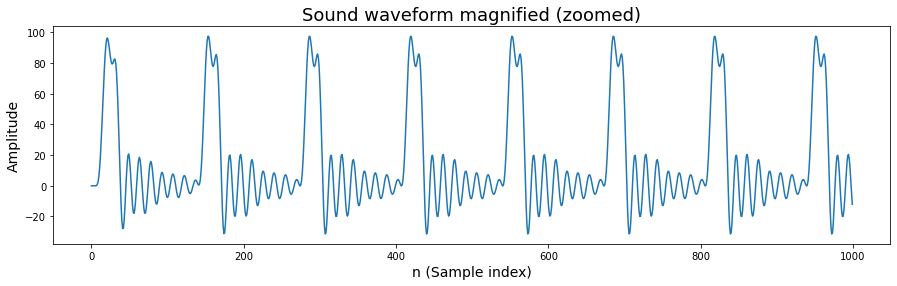

In [18]:
generate_vowel(f0 = 120, f1 = 730, f2 = 1090, f3 = 2440, plot =True)

In [19]:
generate_vowel(f0 = 220, f1 = 730, f2 = 1090, f3 = 2440)

### Vowel /i/

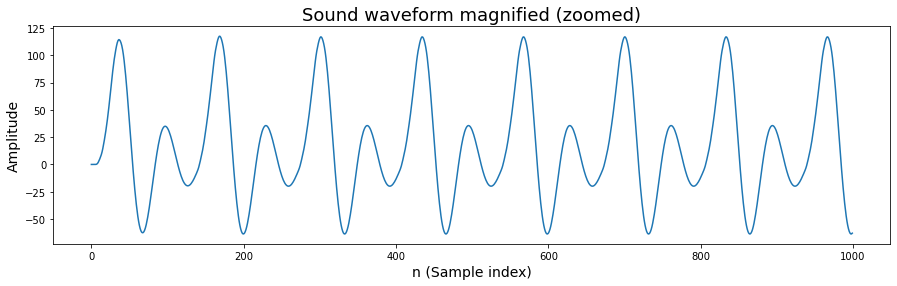

In [20]:
generate_vowel(f0 = 120, f1 = 270, f2 = 2290, f3 = 3010, plot = True)

In [21]:
generate_vowel(f0 = 220, f1 = 270, f2 = 2290, f3 = 3010)

### Vowel /u/

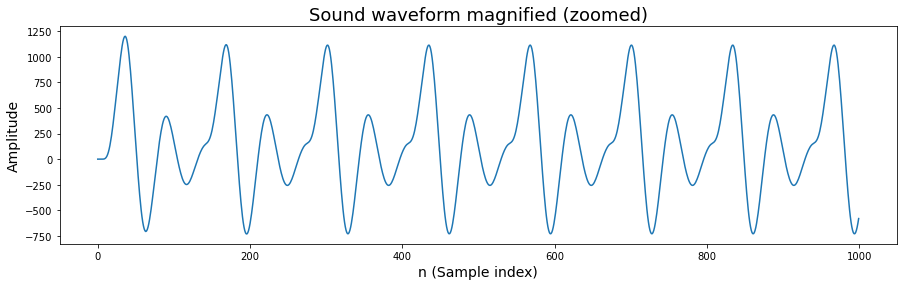

In [22]:
generate_vowel(f0 = 120, f1 = 300, f2 = 870, f3 = 2240, plot = True)

In [23]:
generate_vowel(f0 = 220, f1 = 300, f2 = 870, f3 = 2240)

## Optional Part

### Glottal Pulse Shaping and Lip Radiation Filtering

#### Rosenburg Model for Glottal Pulse:

$ g(n) = \frac{1}{2} [1 - cos(\frac{\pi n}{N_1})]$   for    $0 <n \leq N_1$

$ \ \ \ \ \ \ = cos(\frac{\pi (n - N_1)}{2 N_2})$    for    $N_1 <n \leq N_1 + N_2 $

$ \ \ \ \ \ \ = 0 $ otherwise


**Reference**: A. E. Rosenburg, "Effect of Glottal Pulse Shape on the Quality of Natural Vowels," _J. Acoust. Soc. Am._, Vol. 43, No. 4, pp. 822-828, April 1968

Link: https://asa.scitation.org/doi/citedby/10.1121/1.1912389

Can also be found on **Page 103** of the book **"Digital Processing of Speech Signals"** by L. Rabiner and R. Schafer


The **lip radiation effect** is added by adding a filter in cascade using the lfilter function of scipy:

$$R(z) = 1 - 0.9z^{-1} $$


Adding this glottal shape and the lip radiation effect make the sounds more natural and human

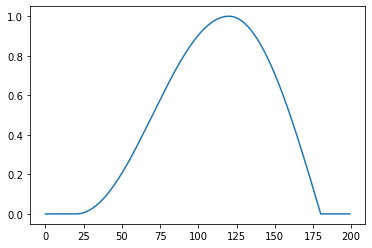

In [24]:
# Rosenburg Model for Glottal Pulse
# Page 103: Rabiner and Schafer

N1 = 100
N2 = 60
t1 = np.arange(0,N1)
pulse1 = (1 - np.cos(pi * t1 / N1))/2

t2 = np.arange(N1, N1 + N2)
pulse2 = np.cos(pi * (t2 - N1) / (2*N2))
pulse3 = np.zeros(20)
# plt.plot(pulse1)
# plt.plot(pulse2)

pulse = np.concatenate([pulse3, pulse1, pulse2, pulse3])

plt.plot(pulse);

In [25]:
def generate_vowel_glottal(f0 = 120, f1 = 730, f2 = 1090, f3 = 2440, b1 = 100, fs = 16000, pw = 40, dur = 0.5, plot = False):
    
    
    pi = np.pi

    T = 1/fs  #sampling interval
    theta1 = 2 * pi * f1 * T
    theta2 = 2 * pi * f2 * T
    theta3 = 2 * pi * f3 * T
    sigma = b1 * pi * T
    r = np.exp(-sigma)
    
    H1z = signal.dlti([1], [1, -2*r*np.cos(theta1), r**2])
    H2z = signal.dlti([1], [1, -2*r*np.cos(theta2), r**2])
    H3z = signal.dlti([1], [1, -2*r*np.cos(theta3), r**2])
    
    
    samples1, response1 = signal.dimpulse(H1z, t = range(150))
    samples2, response2 = signal.dimpulse(H2z, t = range(150))
    samples3, response3 = signal.dimpulse(H3z, t = range(150))
    
    ########## Glottal Pulse Shaping ###########
    
    # Rosenburg Model
    N1 = 100
    N2 = 60
    t1 = np.arange(0,N1)
    pulse1 = (1 - np.cos(pi * t1 / N1))/2
    t2 = np.arange(N1, N1 + N2)
    pulse2 = np.cos(pi * (t2 - N1) / (2*N2))
    pulse3 = np.zeros(20)
    pulse = np.concatenate([pulse3, pulse1, pulse2, pulse3])
    ###############################################

    P = int(fs/f0) #period of impulse train
    num_samples = int(fs * dur)
    imp = signal.unit_impulse(num_samples + 1, [x*P for x in range(0,int(num_samples/P) + 1)])

    xn = signal.convolve(pulse, imp)  #source signal - pulse train
    
    h1n = response1[0].reshape(150)
    h2n = response2[0].reshape(150)
    h3n = response3[0].reshape(150)

    conv1 = signal.convolve(xn, h1n)
    conv2 = signal.convolve(conv1, h2n)
    conv3 = signal.convolve(conv2, h3n)
    
    sn = signal.lfilter([1,-0.9],[1], conv3)  # lip radiation filtering
    
    if plot:
        plt.figure(figsize = (15,4))
        plt.plot(sn[1000:2000])
        plt.title("Sound waveform magnified (zoomed)", fontsize = 18)
        plt.xlabel("n (Sample index)", fontsize = 14)
        plt.ylabel("Amplitude", fontsize = 14)
        plt.show();
    
    return sn, Audio(sn, rate = fs)

### Vowel /a/

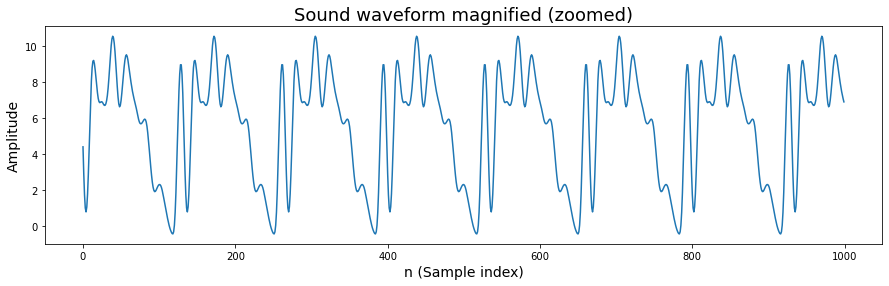

In [26]:
generate_vowel_glottal(f0 = 120, f1 = 730, f2 = 1090, f3 = 2440, plot = True)[1]

In [27]:
generate_vowel_glottal(f0 = 220, f1 = 730, f2 = 1090, f3 = 2440)[1]

### Vowel /i/

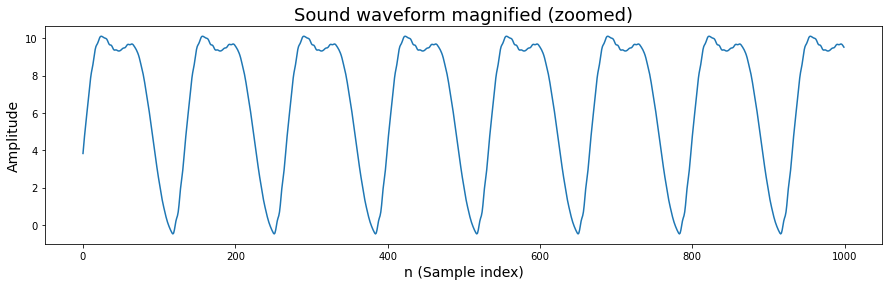

In [28]:
generate_vowel_glottal(f0 = 120, f1 = 270, f2 = 2290, f3 = 3010, plot = True)[1]

In [29]:
generate_vowel_glottal(f0 = 220, f1 = 270, f2 = 2290, f3 = 3010)[1]

### Vowel /u/

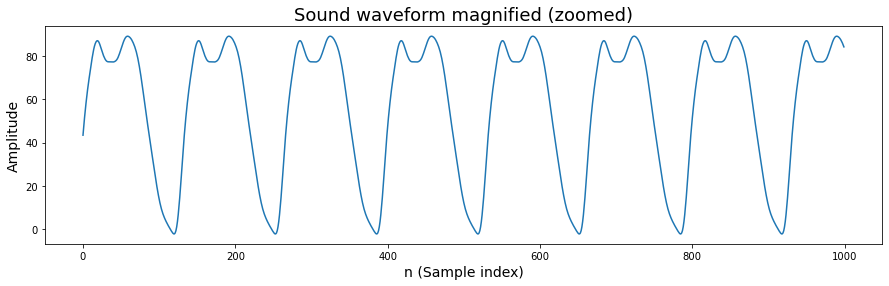

In [30]:
generate_vowel_glottal(f0 = 120, f1 = 300, f2 = 870, f3 = 2240, plot = True)[1]

In [31]:
generate_vowel_glottal(f0 = 220, f1 = 300, f2 = 870, f3 = 2240)[1]

# Extra: 

The formants corresponding to other vowels can be added. Two such vowels have been tried:

1) /e/: f1 = 530, f2 = 1840, f3 = 2480

2) /ae/: f1 = 660, f2 = 1720, f3 = 2410

### Vowel /e/ (as in 'bed')

In [32]:
generate_vowel_glottal(f0 = 120, f1 = 530, f2 = 1840, f3 = 2480)[1]

In [33]:
generate_vowel_glottal(f0 = 220, f1 = 530, f2 = 1840, f3 = 2480)[1]

### Extra: Vowel /ae/ (as in 'bad')

In [34]:
generate_vowel_glottal(f0 = 120, f1 = 660, f2 = 1720, f3 = 2410)[1]

In [35]:
generate_vowel_glottal(f0 = 220, f1 = 660, f2 = 1720, f3 = 2410)[1]

# Playing around with the vowels:

In [36]:
def musical():
     
    a = 2 * generate_vowel_glottal(f0 = 120, f1 = 520, f2 = 1190, f3 = 2390)[0]
    aa = 3 * generate_vowel_glottal(f0 = 135, f1 = 730, f2 = 1090, f3 = 2440)[0]
    i = 2 * generate_vowel_glottal(f0 = 150, f1 = 390, f2 = 1990, f3 = 2550)[0]
    ee = 2 * generate_vowel_glottal(f0 = 160, f1 = 270, f2 = 2290, f3 = 3010)[0]
    u = 2* generate_vowel_glottal(f0 = 180, f1 = 440, f2 = 1020, f3 = 2240)[0]
    oo = generate_vowel_glottal(f0 = 200, f1 = 300, f2 = 870, f3 = 2240)[0]
    e = 2 * generate_vowel_glottal(f0 = 225, f1 = 530, f2 = 1840, f3 = 2480)[0]
    ae = 2 * generate_vowel_glottal(f0 = 240, f1 = 660, f2 = 1720, f3 = 2410)[0]
#     o = 2 * generate_vowel_glottal(f0 = 120, f1 = 570, f2 = 840, f3 = 2410)[0]
    
    sa_re_ga_ma = np.concatenate([a,aa,i,ee,u,oo,e,ae])
    sa_ni_dha_pa = np.flip(sa_re_ga_ma)
    return Audio(sa_re_ga_ma, rate = fs), Audio(sa_ni_dha_pa, rate = fs)

In [39]:
musical()[0]

In [38]:
musical()[1]